In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Q) Design a deep learning model to generate piano music sequences using the Maestro Dataset. Load and process MIDI files into piano roll/token based sequences. Design and train LSTM/GRU/Transformer Model and evaluate its performance

In [ ]:
!pip install pretty_midi

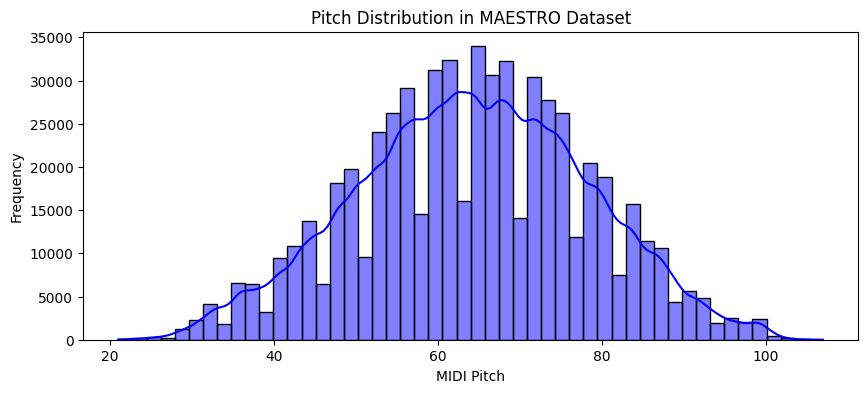

114.0
Training Data Shape: (112, 1000, 128)
Validation Data Shape: (14, 1000, 128)
Test Data Shape: (14, 1000, 128)


In [ ]:
#Extract Notes and Piano_rolls from MIDI Files

import os
import numpy as np
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Define the dataset path
dataset_path = "/content/drive/MyDrive/Music_MAESTRO/maestro-v3.0.0/"

# Load metadata CSV file
metadata_file = os.path.join(dataset_path, "maestro-v3.0.0.csv")
df = pd.read_csv(metadata_file)

selected_years = [2017]
df = df[df['year'].isin(selected_years)]

# Get list of MIDI files
midi_files = [os.path.join(dataset_path, f) for f in df['midi_filename'].tolist()]

# Function to extract note sequences from MIDI
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    notes = []

    for instrument in pm.instruments:
        if instrument.is_drum:
            continue  # Skip drum tracks

        for note in instrument.notes:
            notes.append([note.start, note.end, note.pitch, note.velocity])

    return np.array(notes)

# Process all MIDI files
all_notes = [midi_to_notes(f) for f in midi_files]
all_notes = np.concatenate(all_notes, axis=0)

# Exploratory Data Analysis (EDA) on MIDI Notes
plt.figure(figsize=(10, 4))
sns.histplot(all_notes[:, 2], bins=50, kde=True, color="blue")  # MIDI pitch distribution
plt.xlabel("MIDI Pitch")
plt.ylabel("Frequency")
plt.title("Pitch Distribution in MAESTRO Dataset")
plt.show()

# Function to convert MIDI to piano roll
def midi_to_piano_roll(midi_file, fs=100):
    pm = pretty_midi.PrettyMIDI(midi_file)
    piano_roll = pm.get_piano_roll(fs=fs)  # fs = time steps per second
    return piano_roll.T  # Transpose to have (time_steps, pitch_classes)

# Convert all MIDI files to piano rolls
piano_rolls = [midi_to_piano_roll(f) for f in midi_files]

# Define a fixed maximum sequence length
max_length = 1000

# Pad or truncate sequences to the same length
piano_rolls = [x[:max_length] if x.shape[0] > max_length else np.pad(x, ((0, max_length - x.shape[0]), (0, 0))) for x in piano_rolls]

# Convert to NumPy array
X = np.array(piano_rolls)
max = np.max(X)
print("Maximum Midi Velocity: ")
print(max)

# Train-Test-Validation Split
X_train, X_temp = train_test_split(X, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Normalize input data
X_train = X_train / max  # Normalize MIDI velocities
X_val = X_val / max
X_test = X_test / max

# Print data shapes
print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 1000, 64)            │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1000, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 500, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 500, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 250, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 250, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_2 (UpSampling1D)       │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_3 (UpSampling1D)       │ (None, 1000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1000, 128)           │           8,320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 239,424 (935.25 KB)

 Trainable params: 239,040 (933.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.0059 - loss: 0.6642 - val_accuracy: 0.0000e+00 - val_loss: 0.4698
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0211 - loss: 0.4034 - val_accuracy: 0.0000e+00 - val_loss: 0.2042
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.0164 - loss: 0.1915 - val_accuracy: 0.0000e+00 - val_loss: 0.1169
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.0191 - loss: 0.1156 - val_accuracy: 0.0000e+00 - val_loss: 0.0900
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.0172 - loss: 0.0905 - val_accuracy: 0.0000e+00 - val_loss: 0.0796
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.0178 - loss: 0.0837 - val_accuracy: 0.0000e+00 - val_loss: 0.0744
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.0201 - loss: 0.0758 - val_accuracy: 0.0367 - val_loss: 0.0714
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.0214 - loss: 0.0728 -

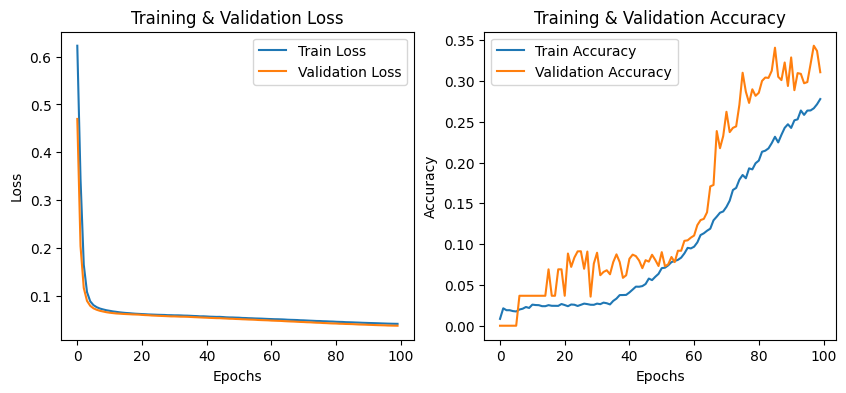

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, BatchNormalization, UpSampling1D

# Define Model
def build_cnn_lstm(input_shape=(1000, 128)):
    model = Sequential()

    # CNN Feature Extraction
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # LSTM for Temporal Learning
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))

    # Upsampling to match the original temporal dimension
    model.add(UpSampling1D(size=2))  # Upsample by a factor of 2
    model.add(UpSampling1D(size=2))  # Upsample by a factor of 2

    # Fully Connected Output Layer (Predict Note Activations)
    model.add(TimeDistributed(Dense(128, activation='sigmoid')))

    # Compile Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Define input shape (time_steps, pitch_classes)
input_shape = (1000, 128)
model = build_cnn_lstm(input_shape)
model.summary()

# Train Model
history = model.fit(
    X_train, X_train,  # Autoencoder-style training
    epochs=100,
    batch_size=8,
    validation_data=(X_val, X_val)
)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, X_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Plot Training History
plt.figure(figsize=(10, 4))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
# Generate Music Sequence
generated_sequence = model.predict(X_test[:1])  # Generate for one test sample

print(generated_sequence)

# Convert Generated Sequence to MIDI
def piano_roll_to_midi(piano_roll, fs=100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    for time, pitch_vector in enumerate(piano_roll):
        for pitch, velocity in enumerate(pitch_vector):
            if velocity > 0:
                note = pretty_midi.Note(
                    velocity=int(velocity * 127),
                    pitch=pitch,
                    start=time / fs,
                    end=(time + 1) / fs
                )
                instrument.notes.append(note)

    pm.instruments.append(instrument)
    return pm

# Convert and save generated MIDI file
generated_midi = piano_roll_to_midi(generated_sequence[0])
generated_midi.write("generated_music.mid")
print("Generated MIDI saved as 'generated_music.mid'")




1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
[[[6.5662316e-04 1.3100143e-03 1.5065094e-03 ... 8.5185369e-04
   6.2444917e-04 2.1217684e-03]
  [6.5662316e-04 1.3100143e-03 1.5065094e-03 ... 8.5185369e-04
   6.2444917e-04 2.1217684e-03]
  [6.5662316e-04 1.3100143e-03 1.5065094e-03 ... 8.5185369e-04
   6.2444917e-04 2.1217684e-03]
  ...
  [2.5919311e-05 7.0540787e-05 8.7663771e-05 ... 3.7851834e-05
   2.6177184e-05 1.4176048e-04]
  [2.5919311e-05 7.0540787e-05 8.7663771e-05 ... 3.7851834e-05
   2.6177184e-05 1.4176048e-04]
  [2.5919311e-05 7.0540787e-05 8.7663771e-05 ... 3.7851834e-05
   2.6177184e-05 1.4176048e-04]]]
Generated MIDI saved as 'generated_music.mid'
